# Dark Photon Equilibrium Time Plots

This notebook is used to generate the contours of equilibrium time

## Initialize the Notebook

In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
            
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

print ('Complete')

Complete


In [2]:
from MasterFunctions_Capture import *
from MasterFunctions_Annihilation import *
from MasterFunctions_Graphing import *
from MasterFunctions_EquilibriumTime import *

print ()
print ('All notebooks imported')

importing Jupyter notebook from MasterFunctions_Capture.ipynb
importing Jupyter notebook from MasterFunctions_ModelData.ipynb
------ MasterFunctions_ModelData Imported ------
------ MasterFunctions_Capture Imported ------
importing Jupyter notebook from MasterFunctions_Annihilation.ipynb
------ MasterFunctions_Annihilation Imported ------
importing Jupyter notebook from MasterFunctions_Graphing.ipynb
------ MasterFunctions_Graphing Loaded ------
importing Jupyter notebook from MasterFunctions_EquilibriumTime.ipynb
------ MasterFunctions_EquilibriumTime Imported ------

All notebooks imported


# Generating the Equilibrium Plots

## Motivation

The most notable consequence of the small energy approximation results in the simple $m_A$ and $\varepsilon$ dependence of the capture rate. Exploiting this dependence, we can now write the capture rate as:

\begin{equation}
C_{cap} = \frac{\varepsilon^2}{m_A^4} \kappa_0 
\end{equation}

where $\kappa_0$ now only depends on $m_X$, $\alpha_X$, and $\alpha$. Thus, the equilibrium time as a function of mediator mass and kinetic mixing parameter has a simple analytic form. The equilibrium time can be inverted to give epsilon as a function of mediator mass and contour line, drastically reducing computation time by allowing python to handle this as a one dimensional function instead of a two dimensional function.

\begin{equation}
\log(\varepsilon) = 2\log(m_A) -\frac{1}{2}\log(\alpha_X \ \kappa_0 \ \langle S_s \rangle \ C_\text{ann,0}) - \log(\mathrm{L} \ \tau_{\oplus})
\end{equation}

This has been written into the function: EpsilonFuncMA

## (UPDATE) The Recipie

The basic recipie is:

1). Read in a Sommerfeld file

2). Interpolate the sommerfeld data

3). Populate the plot Arrays

4). Plot

## Data Input

### Read In Sommerfeld Data and Interpolate

The following cell reads in an external Sommerfeld file and interpolates the discrete set of $\langle S_s (m_A) \rangle$ into a continuous function. This interpolated function is what will be called during the calculation of the equilibrium time instead of calling the Sommerfeld function explicitly. We also determine the correct units of $m_X$ to display once plotted.

In [3]:
sommerfeldFile = input('Sommerfeld Data File: ')

assert sommerfeldFile != ''

readFile = photonSommerfeldPath(sommerfeldFile)

dataIn = pd.read_csv(readFile, sep = ',')

Filem_X = float(dataIn.loc[0]['mX[GeV]'])
FileKappa0 = float(dataIn.loc[0]['Kappa0'])

###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'

if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X*10**-3
    m_XUnit = 'TeV'
    

# Double Check to make sure the file name matches the read-in value
print ('Input m_X: {0} GeV'.format(Filem_X))


###############################
# Interpolate Sommerfeld and alpha_X
###############################
maList = dataIn['mA[GeV]']
sommerfeldList = dataIn['ThermAvgSommerfeld']
SommerfeldInterp = interpolate.interp1d(maList, sommerfeldList)


print ('Compete')

Sommerfeld Data File: 100GeVSommerfeldNew.csv
Input m_X: 100.0 GeV
Compete


### Populate Plot Arrays

The following cell populates the $\varepsilon(m_A)$ arrays over the range $0.01$ GeV $\leq m_A \leq 10$ GeV using 500 data points.

Enter 5 unique contour levels. Note that the contour lines you enter "$\mathrm{L}$" correspond to a contour level of $\frac{\tau}{\tau_{\oplus}} = 10^\mathrm{L}$.

These values are stored as the keys to "$\texttt{contourDictionary}$." By default, the values of this dictionary are an array composed of two sub-arrays. The first sub-array will store the contour lines without Sommerfeld and the second sub-array will store the contour lines with Sommerfeld.

In [4]:
print ('Enter 5 countour lines in ascending or descending order: ')

#contourDictionary = {key: value}
# "key" is the actual contour level
# "value" is an array of plot values: [[],[]] 
# The first one is with sommerfeld off, the second array with sommerfeld on.
         
contourDictionary={}

for i in range(1,6):
    key = (input('Contour Level {0}: '.format(i)))
    type(float(key)) != type(float(0)) # This line ensures that the values entered are numeric
    contourDictionary.update({'{0}'.format(key): [[],[]] } )
    
print ('Complete')

Enter 5 countour lines in ascending or descending order: 
Contour Level 1: -4
Contour Level 2: -2
Contour Level 3: 0
Contour Level 4: 2
Contour Level 5: 4
Complete


### Populate Dictionary Values

The following cell populates $\texttt{contourDictionary}$ with the contour values.

In [5]:
for key in contourDictionary:
    contourDictionary[key] = [[],[]]

##################
# Initialize the x-axis
# 0.01 GeV < m_A < 10 GeV
##################
maRange = np.logspace(-2, 1, 500, base = 10)

##################
# Populate contourDictionary with plot values
##################
maArray = []

for maTemp in maRange:
    maArray.append(maTemp)

for key in contourDictionary:
    contourline = float(key)
    
    for mATemp in maRange:
        Alpha_X    = alphaTherm(Filem_X, mATemp)
        SigmaVTree = photonSigmaVtree(Filem_X, mATemp, Alpha_X)
        Sommerfeld = SommerfeldInterp(mATemp)
        CannNoSomm = CAnnCalc(Filem_X, mATemp, SigmaVTree)
    
        EpsilonNoSomm = EpsilonFuncMA(mATemp, Alpha_X, CannNoSomm, 1, FileKappa0, contourline)
        EpsilonSomm   = EpsilonFuncMA(mATemp, Alpha_X, CannNoSomm, Sommerfeld, FileKappa0, contourline)
    
        contourDictionary[key][0].append(EpsilonNoSomm)
        contourDictionary[key][1].append(EpsilonSomm)


print ('Complete')

Complete


## Plot Produciton

### Single Plot

The following cell produces a single plot of the equilibrium time. You may choose to turn the Sommerfeld enhancement "on" or "off" by following the prompt.

Sommerfeld on? No:0 Yes:1 1
Complete


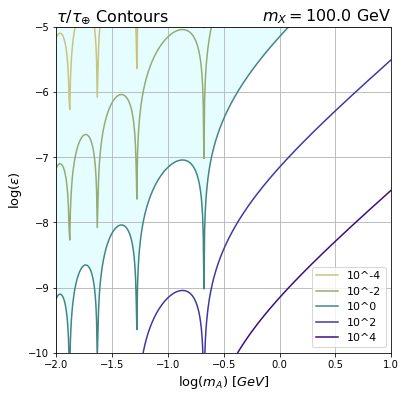

In [6]:
fig1 = plt.figure(figsize = (6,6))

sommParam = int(input('Sommerfeld on? No:0 Yes:1 '))
assert ((sommParam == 0) or (sommParam == 1)), 'Invalid Input, must be 0 or 1.'


####################
# This uses a custom color scheme defined in Masterfunctions_Graphing
####################
colors = colorScheme1
mpl.rcParams['axes.prop_cycle'] = colors

####################
# Produce the contour lines
####################
testFill = False
for key in contourDictionary:
    
    if (float(key) == 0):
        testFill = True
    assert (len(maRange) == len(contourDictionary[key][sommParam])), 'ContourDictionary is probably not populated'
    plt.plot(np.log10(maRange), (contourDictionary[key][sommParam]), label = r'10^{0}'.format(key))
    
####################  
# Fill the valid search region  
####################
if (testFill == True):
    xs = np.log10(maArray)
    y1 = contourDictionary['0'][sommParam]
    plt.fill_between(xs, y1, -5, color = '#E6FDFF')



    
plt.legend(loc = 'lower right', fontsize = '11')
plt.xlabel(r'$\log(m_A)$ $[GeV]$', fontsize = '13')
plt.ylabel(r'$\log(\varepsilon)$', fontsize = '13')

plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),\
          fontsize = '16',\
          loc = 'right')

plt.title(r'$\tau/\tau_{\oplus}$ Contours',\
          fontsize = '16',\
          loc = 'left')
plt.axis([np.log10(min(maRange)),np.log10(max(maRange)),-10,-5])
plt.grid()

print ('Complete')

#### Save Figure

In [ ]:
filename = input('Figure Name: ')
fig1.savefig(photonEquilibriumPath(filename), dpi = 700)

print ('Complete')

### Side-by-side Comparison

Complete


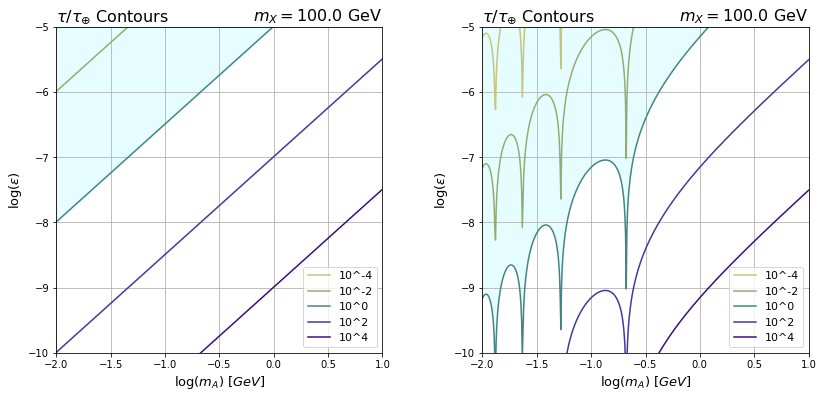

In [10]:
colors = colorScheme1

###############################
# Initialize Figure
###############################
fig2 = plt.figure(figsize = (14,6))
mpl.rcParams['axes.prop_cycle'] = colors

###############################
# No Sommerfeld Plot
###############################
ax1 = fig2.add_subplot(121)
ax1.set_aspect(0.6)


# Contour Lines
testFill1 = False
for key in contourDictionary:
    if (float(key) == 0):
        testFill1 = True
    plt.plot(np.log10(maRange), (contourDictionary[key][0]), label = r'10^{0}'.format(key))


if (testFill1 == True):
    xs = np.log10(maArray)
    y1 = contourDictionary['0'][0]
    plt.fill_between(xs, y1, -5, color = '#E6FDFF')

    
plt.legend(loc = 'lower right', fontsize = '11')
plt.xlabel(r'$\log(m_A)$ $[GeV]$', fontsize = '13')
plt.ylabel(r'$\log(\varepsilon)$', fontsize = '13')

plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),\
          fontsize = '16',\
          loc = 'right')

plt.title(r'$\tau/\tau_{\oplus}$ Contours',\
          fontsize = '16',\
          loc = 'left')
plt.axis([np.log10(min(maRange)),np.log10(max(maRange)),-10,-5])
plt.grid()
 


###############################
# Sommerfeld Plot
###############################
ax2 = fig2.add_subplot(122)
ax2.set_aspect(0.6)

# Contour Lines
testFill2 = False
for key in contourDictionary:
    if (float(key) == 0):
        testFill2 = True
    plt.plot(np.log10(maRange), (contourDictionary[key][1]), label = r'10^{0}'.format(key))


if (testFill2 == True):
    xs = np.log10(maArray)
    y1 = contourDictionary['0'][1]
    plt.fill_between(xs, y1, -5, color = '#E6FDFF')
    
    
# Define plot properties
plt.legend(loc = 'lower right', fontsize = '11')
plt.xlabel(r'$\log(m_A)$ $[GeV]$',fontsize = '13')
plt.ylabel(r'$\log(\varepsilon)$',fontsize = '13')

plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),\
          fontsize = '16',\
          loc = 'right')

plt.title(r'$\tau/\tau_{\oplus}$ Contours',\
          fontsize = '16',\
          loc = 'left')
plt.axis([np.log10(min(maRange)),np.log10(max(maRange)),-10,-5])
plt.grid()
    

print ('Complete')

#### Save Figure

In [ ]:
filename = input('Figure Name: ')
fig2.savefig(photonEquilibriumPath(filename), dpi = 700)

print ('Complete')